<div id="singlestore-header" style="display: flex; background-color: rgba(235, 249, 245, 0.25); padding: 5px;">
    <div id="icon-image" style="width: 90px; height: 90px;">
        <img width="100%" height="100%" src="https://raw.githubusercontent.com/singlestore-labs/spaces-notebooks/master/common/images/header-icons/browser.png" />
    </div>
    <div id="text" style="padding: 5px; margin-left: 10px;">
        <div id="badge" style="display: inline-block; background-color: rgba(0, 0, 0, 0.15); border-radius: 4px; padding: 4px 8px; align-items: center; margin-top: 6px; margin-bottom: -2px; font-size: 80%">SingleStore Notebooks</div>
        <h1 style="font-weight: 500; margin: 8px 0 0 4px;">Demonstrate ML function Anomaly Detect</h1>
    </div>
</div>

<div class="alert alert-block alert-warning">
    <b class="fa fa-solid fa-exclamation-circle"></b>
    <div>
        <p><b>Note</b></p>
        <p>You can use your existing Standard or Premium workspace with this Notebook.</p>
    </div>
</div>


This feature is currently in **Private Preview**. Please reach out to support@singlestore.com to confirm if this feature can be enabled in your org.

This Jupyter notebook will help you:
1. Download the bank transaction dataset from kaggle for anomaly detection
2. Store the data in a SingleStore table
3. Use ML Functions for training and predictions
4. Visualize the results of anomaly detection on test dataset

**Prerequisites**: Ensure ML Functions are installed on your deployment (AI > AI & ML Functions).

## Step 1: Import necessary Libraries

In [1]:
pip install -q kagglehub

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pandas as pd
import singlestoredb as s2
import json
import kagglehub
import getpass
from singlestoredb import create_engine
from IPython.display import display

import plotly.graph_objects as go
from plotly.subplots import make_subplots

## Step 2: Test Connection to SingleStore

In [3]:
# Ensure that you have selected a SinglestoreDB connection (workspace) before running this cell
try:
    conn = s2.connect()
    conn.autocommit(True) # Set autocommit for notebook simplicity
    print("Connection successful!")
except Exception as e:
    print(f"Connection failed: {e}")

Connection successful!


## Step 3: Create Database and Tables

In [4]:
# Create the database
db_name = "temp"

try:
    conn.cursor().execute(f"CREATE DATABASE IF NOT EXISTS {db_name};")
    conn.cursor().execute(f"USE {db_name};")
    print(f"Database '{db_name}' is ready.")
except Exception as e:
    print(e)

Database 'temp' is ready.


## Step 4: Prepare and Load Data

We will use a publicly available Kaggle Bank Transactions dataset. We'll download the data into Pandas DataFrames and then load them into SingleStore.

<div class="alert alert-block alert-warning">
    <b class="fa fa-solid fa-exclamation-circle"></b>
    <div>
        <p><b>Note</b></p>
        <p>You may need to whitelist your Firewall to allow this notebook instance to access the Kaggle server url. In case the notebook doesn't have access, a Toast message will appear guiding you to add this url when running the following code cell.</p>
    </div>
</div>

In [5]:
print("Downloading dataset from Kaggle...")
path = kagglehub.dataset_download("valakhorasani/bank-transaction-dataset-for-fraud-detection")
print(f"Dataset downloaded to: {path}")

# Read the CSV file
df = pd.read_csv(f"{path}/bank_transactions_data_2.csv")
df["TransactionDate"] = pd.to_datetime(df["TransactionDate"], format="%Y-%m-%d %H:%M:%S", errors="coerce")
df["PreviousTransactionDate"] = pd.to_datetime(df["PreviousTransactionDate"], format="%Y-%m-%d %H:%M:%S", errors="coerce")
# Display dataset info
print(f"\nDataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst few rows:")
df.head()

Dataset downloaded to: /home/jovyan/.cache/kagglehub/datasets/valakhorasani/bank-transaction-dataset-for-fraud-detection/versions/4

Dataset shape: (2512, 16)
Columns: ['TransactionID', 'AccountID', 'TransactionAmount', 'TransactionDate', 'TransactionType', 'Location', 'DeviceID', 'IP Address', 'MerchantID', 'Channel', 'CustomerAge', 'CustomerOccupation', 'TransactionDuration', 'LoginAttempts', 'AccountBalance', 'PreviousTransactionDate']

First few rows:


,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,2024-11-04 08:08:08
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,2024-11-04 08:09:35
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19,Student,56,1,1122.35,2024-11-04 08:07:04
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26,Student,25,1,8569.06,2024-11-04 08:09:06
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,26,Student,198,1,7429.40,2024-11-04 08:06:39


In [6]:
try:
    # Create a SQLAlchemy engine
    engine = s2.create_engine(database=db_name)

    # Use pandas.to_sql to load the complete data to a table
    df.to_sql("metrics", con=engine, if_exists='append', index=False)

    print("Data loading complete.")
except Exception as e:
    print(f"Error loading data: {e}")

Data loading complete.


## Create Train Test splits from complete data

Ensure that the rows belonging to the same sequence are grouped in the same split. The following SQL query takes care of this split

In [7]:
%%sql
USE "temp";

DROP TABLE IF EXISTS training_data;
DROP TABLE IF EXISTS test_data;

-- Training set
CREATE TABLE training_data AS
SELECT *
FROM (
    SELECT
        *,
        ROW_NUMBER() OVER (ORDER BY TransactionDate) AS rn,
        COUNT(*) OVER () AS total_rows
    FROM temp.metrics
) t
WHERE rn <= 0.8 * total_rows
ORDER BY TransactionDate;

-- Test set
CREATE TABLE test_data AS
SELECT *
FROM (
    SELECT
        *,
        ROW_NUMBER() OVER (ORDER BY TransactionDate) AS rn,
        COUNT(*) OVER () AS total_rows
    FROM temp.metrics
) t
WHERE rn > 0.8 * total_rows
ORDER BY TransactionDate;

2009 rows affected.

503 rows affected.

""


### Pre-process train data set to include recent context rows

1. Combine the last N (e.g., 20) most recent rows from `train_data` with all rows from `test_data`, forming a continuous chronological dataset.
2. The last N rows help provide recent context for model evaluation.
3. The most recent 20 rows are then excluded from the final result since they are used only for observing short-term trends.

In [8]:
%%sql
USE temp;

-- Drop old context table if it exists
DROP TABLE IF EXISTS test_data_with_history;

-- Create a new test_data_with_history table:
-- includes the last 20 rows from training_data + all rows from test_data
CREATE TABLE test_data_with_history AS
SELECT *
FROM (
    SELECT *
    FROM (
        SELECT *
        FROM training_data
        ORDER BY TransactionDate DESC
        LIMIT 20
    ) recent_training
    UNION ALL
    SELECT *
    FROM test_data
)
ORDER BY TransactionDate ASC;

523 rows affected.

""


## Step 5: Train the Anomaly Detection Model

Now we'll use the `%%s2ml` train cell magic to train our AnomalyDetection model.

In [9]:
%s2ml list

[INFO] Fetched 2 model(s)


,id,name,modelType,status,dbName,targetTable,targetColumn,targetTimeColumn,createdAt,generatedAt
0,174365d5-0135-47af-bf4f-2a582a03b5ba,cc_anomaly_model_v1,AnomalyDetection,Completed,temp,training_data,TransactionAmount,TransactionDate,2025-10-30T21:40:45.28452Z,None
1,152542fa-8786-4d2c-ad8d-49732a9a3a92,cc_anomaly_model_v2,AnomalyDetection,Completed,temp,training_data,TransactionAmount,TransactionDate,2025-10-24T08:13:25.101083Z,None


### Optionally delete any previous model

In [10]:
%s2ml delete --model cc_anomaly_model_v1 --f

{'status': 'deleted',
 'modelID': '174365d5-0135-47af-bf4f-2a582a03b5ba',
 'model': 'cc_anomaly_model_v1'}

In [11]:
%%s2ml train as anomaly_model
task: AnomalyDetection
model: cc_anomaly_model_v1
db: temp
input_table: training_data
target_column: TransactionAmount
target_time_column: TransactionDate
target_series_column: Channel
description: "Training a anomaly detection model"
runtime: cpu-small
selected_features: {"mode":"*","features":null}
force: True

[s2ml] Result assigned to variable: anomaly_model


## Step 6: Check Model Status

Model training is an asynchronous job. We can use the `%s2ml` status magic to check on its progress. The model is ready to use when the status shows `Completed`.

(This may take a minute or two. Re-run the cell to refresh the status.)

In [12]:
%s2ml status --model cc_anomaly_model_v1

[INFO] Model 'cc_anomaly_model_v1' | status=Completed  |  job status=Completed  |  error message=None


'Completed'

In [13]:
print(json.dumps(anomaly_model, indent=4))

{
    "status": "created",
    "result": {
        "modelID": "f171c171-f8cf-4403-9bc9-213fab4183e1",
        "name": "cc_anomaly_model_v1",
        "description": "Training a anomaly detection model",
        "modelType": "AnomalyDetection",
        "projectID": "b45ad4a4-a620-4ed0-9ffc-76d83ebf9bc7",
        "dbName": "temp",
        "targetTable": "training_data",
        "targetColumn": "TransactionAmount",
        "targetTimeColumn": "TransactionDate",
        "pipelineVersion": "v1",
        "createdAt": "2025-10-30T22:12:39.43355Z",
        "createdBy": "5b45981c-8b09-4ead-bec0-09547d7b9a97"
    }
}


## Step 7: Run Predictions

Once the model is COMPLETED, you can use it directly in SQL via the ML_ANOMALY_DETECT() function.

Here is an example prediction for one row

In [14]:
%%sql
show tables in temp;

4 rows affected.

,Tables_in_temp
0,metrics
1,test_data
2,test_data_with_history
3,training_data


### Run the model on a subset of data to view the results format

In [15]:
%%sql
SELECT COUNT(*) as test_count FROM test_data_with_history;

1 rows affected.

,test_count
0,523


In [16]:
%%sql
SELECT * FROM test_data_with_history ORDER BY TransactionDate ASC LIMIT 10;

10 rows affected.

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate,rn,total_rows
0,TX002239,AC00251,433.53,2023-10-19 17:06:57,Debit,Philadelphia,D000573,166.79.195.157,M098,Branch,38,Doctor,231,1,6368.32,2024-11-04 08:09:08,1990,2512
1,TX001482,AC00178,112.27,2023-10-19 17:34:53,Debit,Seattle,D000690,199.6.127.153,M007,Branch,58,Doctor,102,1,7369.89,2024-11-04 08:11:23,1991,2512
2,TX001616,AC00030,363.84,2023-10-19 17:41:40,Debit,Columbus,D000069,26.240.219.199,M048,Online,73,Retired,118,3,5415.64,2024-11-04 08:09:37,1992,2512
3,TX001732,AC00333,1.93,2023-10-19 18:06:08,Debit,Chicago,D000297,162.58.247.55,M030,Branch,47,Doctor,175,5,5684.09,2024-11-04 08:08:33,1993,2512
4,TX001172,AC00044,487.32,2023-10-19 18:11:23,Debit,Kansas City,D000345,35.73.67.98,M005,Branch,52,Doctor,164,1,7707.96,2024-11-04 08:09:23,1994,2512
5,TX001375,AC00447,211.69,2023-10-20 16:02:07,Debit,Atlanta,D000674,200.13.225.150,M066,Branch,30,Doctor,111,1,6412.85,2024-11-04 08:07:50,1995,2512
6,TX002282,AC00225,589.89,2023-10-20 16:29:44,Debit,Jacksonville,D000252,88.55.149.101,M028,Branch,56,Engineer,213,3,9404.63,2024-11-04 08:12:03,1996,2512
7,TX000074,AC00110,233.92,2023-10-20 16:54:28,Credit,Jacksonville,D000295,152.140.239.181,M046,Online,26,Student,280,1,6537.62,2024-11-04 08:08:45,1997,2512
8,TX000087,AC00303,24.56,2023-10-20 17:27:35,Debit,Mesa,D000428,16.131.3.140,M033,Branch,64,Doctor,69,1,9869.93,2024-11-04 08:12:05,1998,2512
9,TX001602,AC00095,10.92,2023-10-20 17:48:44,Debit,Jacksonville,D000383,88.55.149.101,M090,ATM,67,Retired,268,1,7567.20,2024-11-04 08:08:28,1999,2512


In [17]:
%%sql
SELECT cluster.ML_ANOMALY_DETECT('cc_anomaly_model_v1', TO_JSON(selected_data.*)) AS is_anomaly
FROM (SELECT * FROM temp.test_data_with_history ORDER BY TransactionDate ASC) AS selected_data;

1025 rows affected.

,is_anomaly
0,"{""Series"": ""ATM"", ""TS"": ""2023-10-23T16:50:33"",..."
1,"{""Series"": ""ATM"", ""TS"": ""2023-10-23T16:45:37"",..."
2,"{""Series"": ""Branch"", ""TS"": ""2023-10-23T16:15:0..."
3,"{""Series"": ""Online"", ""TS"": ""2023-10-25T16:21:1..."
4,"{""Series"": ""Online"", ""TS"": ""2023-10-26T16:54:3..."
5,"{""Series"": ""Branch"", ""TS"": ""2023-11-27T16:27:5..."
6,"{""Series"": ""Branch"", ""TS"": ""2023-12-19T16:39:5..."
7,"{""Series"": ""ATM"", ""TS"": ""2023-10-23T17:16:20"",..."
8,"{""Series"": ""ATM"", ""TS"": ""2023-11-16T16:33:22"",..."
9,"{""Series"": ""ATM"", ""TS"": ""2023-11-17T17:59:11"",..."


## Step 8: Visualize Anomalies

In [18]:
# Run Predictions
cursor = conn.cursor();

test_data_count = f"""
    SELECT count(*) FROM temp.test_data;
"""
cursor.execute(test_data_count)

QUERY_LIMIT = cursor.fetchall()[0][0]  # Number of records to analyze

In [19]:
# Run Predictions
predictions = f"""
    SELECT cluster.ML_ANOMALY_DETECT('cc_anomaly_model_v1', TO_JSON(selected_data.*)) AS is_anomaly
    FROM (SELECT * FROM temp.test_data_with_history ORDER BY TransactionDate ASC) AS selected_data;
"""

cursor.execute(predictions)


# Parse and prepare data for visualization

column_names = [desc[0] for desc in cursor.description]
df = pd.DataFrame(list(cursor.fetchall()), columns=column_names)

print(f"✓ Retrieved {len(df)} records from database")


df.head()

✓ Retrieved 523 records from database


,is_anomaly
0,"{""Series"": ""Online"", ""TS"": ""2023-10-23T18:37:4..."
1,"{""Series"": ""Online"", ""TS"": ""2023-10-24T17:09:4..."
2,"{""Series"": ""Online"", ""TS"": ""2023-10-30T16:38:1..."
3,"{""Series"": ""ATM"", ""TS"": ""2023-11-01T16:09:05"",..."
4,"{""Series"": ""ATM"", ""TS"": ""2023-11-03T16:50:20"",..."


✓ Filtered out 0 error/invalid rows
✓ Processing 523 valid prediction rows
✓ JSON keys found: ['Series', 'TS', 'Actual', 'Forecast', 'Lower bound', 'Upper bound', 'is_Anomaly', 'percentile', 'distance']
✓ Expanded columns: ['Series', 'TS', 'Actual', 'Forecast', 'Lower bound', 'Upper bound', 'is_Anomaly', 'percentile', 'distance']
Before drop: 523
✓ Ignored the first 20 warm-up rows used for context.
After drop: 503
✓ Data preparation complete
✓ Found 3 unique series types: ATM, Branch, Online


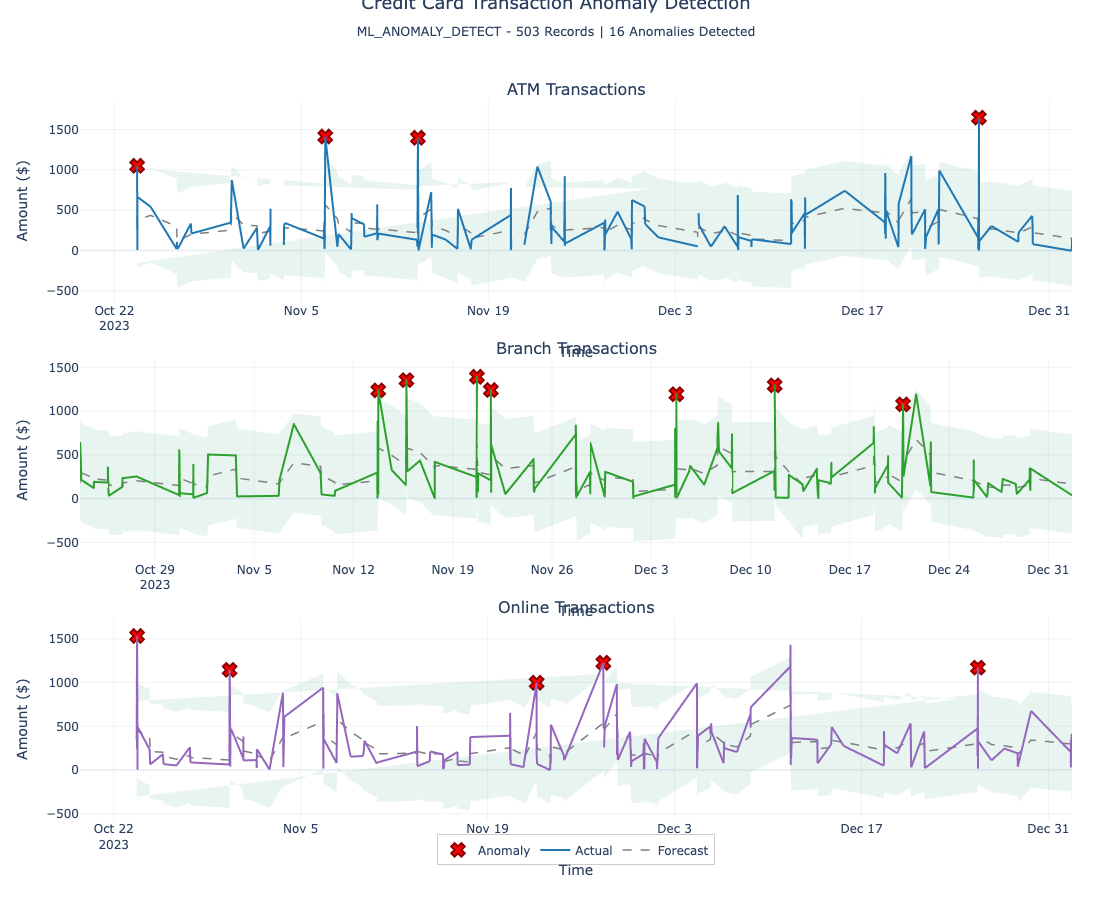


                         ANOMALY DETECTION SUMMARY                         
Total records analyzed: 503
Date range: 2023-10-23 to 2024-01-01
Anomalies detected: 16
Overall anomaly rate: 3.18%

Unique series types: 3

Breakdown by Series:
---------------------------------------------------------------------------
  ATM         :   4/ 158 anomalies ( 2.53%) | Avg: $ 297.85 | Max: $ 1647.74
  Branch      :   7/ 175 anomalies ( 4.00%) | Avg: $ 283.22 | Max: $ 1392.54
  Online      :   5/ 170 anomalies ( 2.94%) | Avg: $ 311.43 | Max: $ 1531.31


In [20]:
# ============================================
# AI generated code to visualize Predictions
# ============================================

SERIES_COLORS = {
    'ATM': '#1f77b4',
    'Branch': '#2ca02c',
    'Online': '#9467bd',
    'POS': '#d62728',
    'Mobile': '#ff7f0e'
}
DEFAULT_COLOR = '#8c564b'

# Parse JSON and filter out error rows
def safe_parse_json(x):
    try:
        parsed = json.loads(x)
        # Check if it's an error response
        if 'error' in parsed:
            return None
        return parsed
    except:
        return None

df['is_anomaly_parsed'] = df['is_anomaly'].apply(safe_parse_json)

# Filter out rows that failed to parse or had errors
df_valid = df[df['is_anomaly_parsed'].notna()].copy()
print(f"✓ Filtered out {len(df) - len(df_valid)} error/invalid rows")
print(f"✓ Processing {len(df_valid)} valid prediction rows")

if len(df_valid) == 0:
    print("❌ No valid predictions found. All rows contain errors.")
    print("\nSample error:")
    print(df['is_anomaly'].iloc[0])
else:
    # Check what keys are in the JSON
    print(f"✓ JSON keys found: {list(df_valid['is_anomaly_parsed'].iloc[0].keys())}")

    # Expand JSON into separate columns
    df_expanded = pd.json_normalize(df_valid['is_anomaly_parsed'])

    print(f"✓ Expanded columns: {list(df_expanded.columns)}")

    # Combine dataframes
    df_final = pd.concat([df_valid.reset_index(drop=True), df_expanded], axis=1)

    # Handle potential case sensitivity in column names
    # Check for different possible timestamp column names
    timestamp_col = None
    for possible_name in ['TS', 'ts', 'Ts', 'timestamp', 'Timestamp']:
        if possible_name in df_final.columns:
            timestamp_col = possible_name
            break

    if timestamp_col is None:
        print("Available columns:", list(df_final.columns))
        raise ValueError("Could not find timestamp column. Please check the column names above.")

    # Convert timestamp to datetime
    df_final['TS'] = pd.to_datetime(df_final[timestamp_col])
    print("Before drop:", len(df_final))

    # --- DROP WARM-UP CONTEXT ROWS ---
    warmup_count = 20
    df_final = df_final.sort_values('TS').reset_index(drop=True)
    if len(df_final) > warmup_count:
        df_final = df_final.iloc[warmup_count:].reset_index(drop=True)
    print(f"✓ Ignored the first {warmup_count} warm-up rows used for context.")
    print("After drop:", len(df_final))


    # Handle potential case sensitivity for Series column
    series_col = None
    for possible_name in ['Series', 'series', 'SERIES']:
        if possible_name in df_final.columns:
            series_col = possible_name
            break

    if series_col is None:
        raise ValueError("Could not find Series column")

    # Standardize column name
    if series_col != 'Series':
        df_final['Series'] = df_final[series_col]

    # Filter out any null Series values before sorting
    df_final = df_final[df_final['Series'].notna()].copy()

    # Handle potential case sensitivity for other columns
    column_mapping = {
        'Actual': ['Actual', 'actual'],
        'Forecast': ['Forecast', 'forecast'],
        'Lower bound': ['Lower bound', 'lower bound', 'lower_bound'],
        'Upper bound': ['Upper bound', 'upper bound', 'upper_bound'],
        'is_Anomaly': ['is_Anomaly', 'is_anomaly', 'isAnomaly']
    }

    for standard_name, possible_names in column_mapping.items():
        for possible_name in possible_names:
            if possible_name in df_final.columns:
                if possible_name != standard_name:
                    df_final[standard_name] = df_final[possible_name]
                break

    print(f"✓ Data preparation complete")


    # STEP 3: Dynamic series configuration

    series_types = sorted([s for s in df_final['Series'].unique() if isinstance(s, str)])
    num_series = len(series_types)

    print(f"✓ Found {num_series} unique series types: {', '.join(series_types)}")

    subplot_titles = [f"{series} Transactions" for series in series_types]
    row_heights = [1.0 / num_series] * num_series


    # STEP 4: Create optimized Plotly visualization

    fig = make_subplots(
        rows=num_series,
        cols=1,
        subplot_titles=tuple(subplot_titles),
        vertical_spacing=0.08,
        row_heights=row_heights
    )

    for idx, series_type in enumerate(series_types, start=1):
        series_data = df_final[df_final['Series'] == series_type].sort_values('TS')
        series_color = SERIES_COLORS.get(series_type, DEFAULT_COLOR)

        # Add confidence interval (upper bound)
        fig.add_trace(go.Scatter(
            x=series_data['TS'],
            y=series_data['Upper bound'],
            mode='lines',
            line=dict(width=0),
            showlegend=False,
            hoverinfo='skip',
            name='Upper Bound'
        ), row=idx, col=1)

        # Add confidence interval (lower bound with fill)
        fig.add_trace(go.Scatter(
            x=series_data['TS'],
            y=series_data['Lower bound'],
            mode='lines',
            line=dict(width=0),
            fillcolor='rgba(68, 168, 129, 0.12)',
            fill='tonexty',
            showlegend=False,
            hoverinfo='skip',
            name='Lower Bound'
        ), row=idx, col=1)

        # Add forecast line
        fig.add_trace(go.Scatter(
            x=series_data['TS'],
            y=series_data['Forecast'],
            mode='lines',
            name='Forecast',
            line=dict(color='gray', dash='dash', width=1.5),
            showlegend=(idx==1),
            hovertemplate='<b>Forecast</b><br>%{x}<br>$%{y:.2f}<extra></extra>'
        ), row=idx, col=1)

        # Add actual values - Use Scattergl for performance
        fig.add_trace(go.Scattergl(
            x=series_data['TS'],
            y=series_data['Actual'],
            mode='lines',
            name='Actual',
            line=dict(color=series_color, width=2),
            showlegend=(idx==1),
            hovertemplate='<b>Actual</b><br>%{x}<br>$%{y:.2f}<extra></extra>'
        ), row=idx, col=1)

        # Highlight anomalies
        anomalies = series_data[series_data['is_Anomaly'] == True]
        if len(anomalies) > 0:
            fig.add_trace(go.Scatter(
                x=anomalies['TS'],
                y=anomalies['Actual'],
                mode='markers',
                name='Anomaly',
                marker=dict(
                    size=12,
                    color='red',
                    symbol='x',
                    line=dict(width=2, color='darkred')
                ),
                showlegend=(idx==1),
                hovertemplate='<b>⚠️ ANOMALY</b><br>%{x}<br>$%{y:.2f}<extra></extra>'
            ), row=idx, col=1)

        # Update axes
        fig.update_xaxes(title_text="Time", row=idx, col=1, showgrid=True, gridwidth=1, gridcolor='rgba(128,128,128,0.1)')
        fig.update_yaxes(title_text="Amount ($)", row=idx, col=1, showgrid=True, gridwidth=1, gridcolor='rgba(128,128,128,0.1)')


    # STEP 5: Optimized layout
    plot_height = max(900, 280 * num_series)

    fig.update_layout(
        height=plot_height,
        width=1400,
        title={
            'text': f"Credit Card Transaction Anomaly Detection<br><sub>ML_ANOMALY_DETECT - {len(df_final):,} Records | {df_final['is_Anomaly'].sum()} Anomalies Detected</sub>",
            'x': 0.5,
            'xanchor': 'center',
            'y': 0.99,
            'yanchor': 'top',
            'font': {'size': 18}
        },
        hovermode='closest',
        showlegend=True,
        legend=dict(
            orientation="h",
            yanchor="top",
            y=-0.02,
            xanchor="center",
            x=0.5,
            bgcolor='rgba(255,255,255,0.9)',
            bordercolor='rgba(0,0,0,0.2)',
            borderwidth=1,
            font=dict(size=12)
        ),
        template='plotly_white',
        margin=dict(l=80, r=40, t=100, b=80),
    )

    fig.show()


    # STEP 6: Enhanced summary statistics

    print("\n" + "="*75)
    print(f"{'ANOMALY DETECTION SUMMARY':^75}")
    print("="*75)
    print(f"Total records analyzed: {len(df_final):,}")
    print(f"Date range: {df_final['TS'].min().strftime('%Y-%m-%d')} to {df_final['TS'].max().strftime('%Y-%m-%d')}")
    print(f"Anomalies detected: {df_final['is_Anomaly'].sum()}")
    print(f"Overall anomaly rate: {(df_final['is_Anomaly'].sum() / len(df_final) * 100):.2f}%")
    print(f"\nUnique series types: {num_series}")
    print("\nBreakdown by Series:")
    print("-"*75)

    for series in series_types:
        series_df = df_final[df_final['Series'] == series]
        series_count = len(series_df)
        anomaly_count = series_df['is_Anomaly'].sum()
        anomaly_rate = (anomaly_count/series_count*100) if series_count > 0 else 0
        series_avg = series_df['Actual'].mean()
        series_max = series_df['Actual'].max()

        print(f"  {series:12s}: {anomaly_count:3d}/{series_count:4d} anomalies ({anomaly_rate:5.2f}%) | "
              f"Avg: ${series_avg:7.2f} | Max: ${series_max:8.2f}")

    print("="*75)

## Step 9: Cleanup

Run these following commands to cleanup all the created resources

In [21]:
%%sql
USE temp;

-- Drop all tables created during the demo
DROP TABLE IF EXISTS results_table;
DROP TABLE IF EXISTS predict_table;
DROP TABLE IF EXISTS train_table;
DROP TABLE IF EXISTS transactions;
DROP TABLE IF EXISTS test_data_with_history;

-- Drop the database
DROP DATABASE IF EXISTS temp;

3 rows affected.

""


<div id="singlestore-footer" style="background-color: rgba(194, 193, 199, 0.25); height:2px; margin-bottom:10px"></div>
<div><img src="https://raw.githubusercontent.com/singlestore-labs/spaces-notebooks/master/common/images/singlestore-logo-grey.png" style="padding: 0px; margin: 0px; height: 24px"/></div>